<a href="https://colab.research.google.com/github/mariaeduardaoer/AHP/blob/main/AHP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analytic Hierarchy Process (AHP)

Técnica MCDA voltada para solução de problemas de escolha baseada na Teoria da medição relativa: comparação de pares de alternativas para produzir uma classificação relativa. O interesse está na diferença entre uma alternativa sobre outra e não na medição exata do desempenho das alternativas sobre os critérios.


 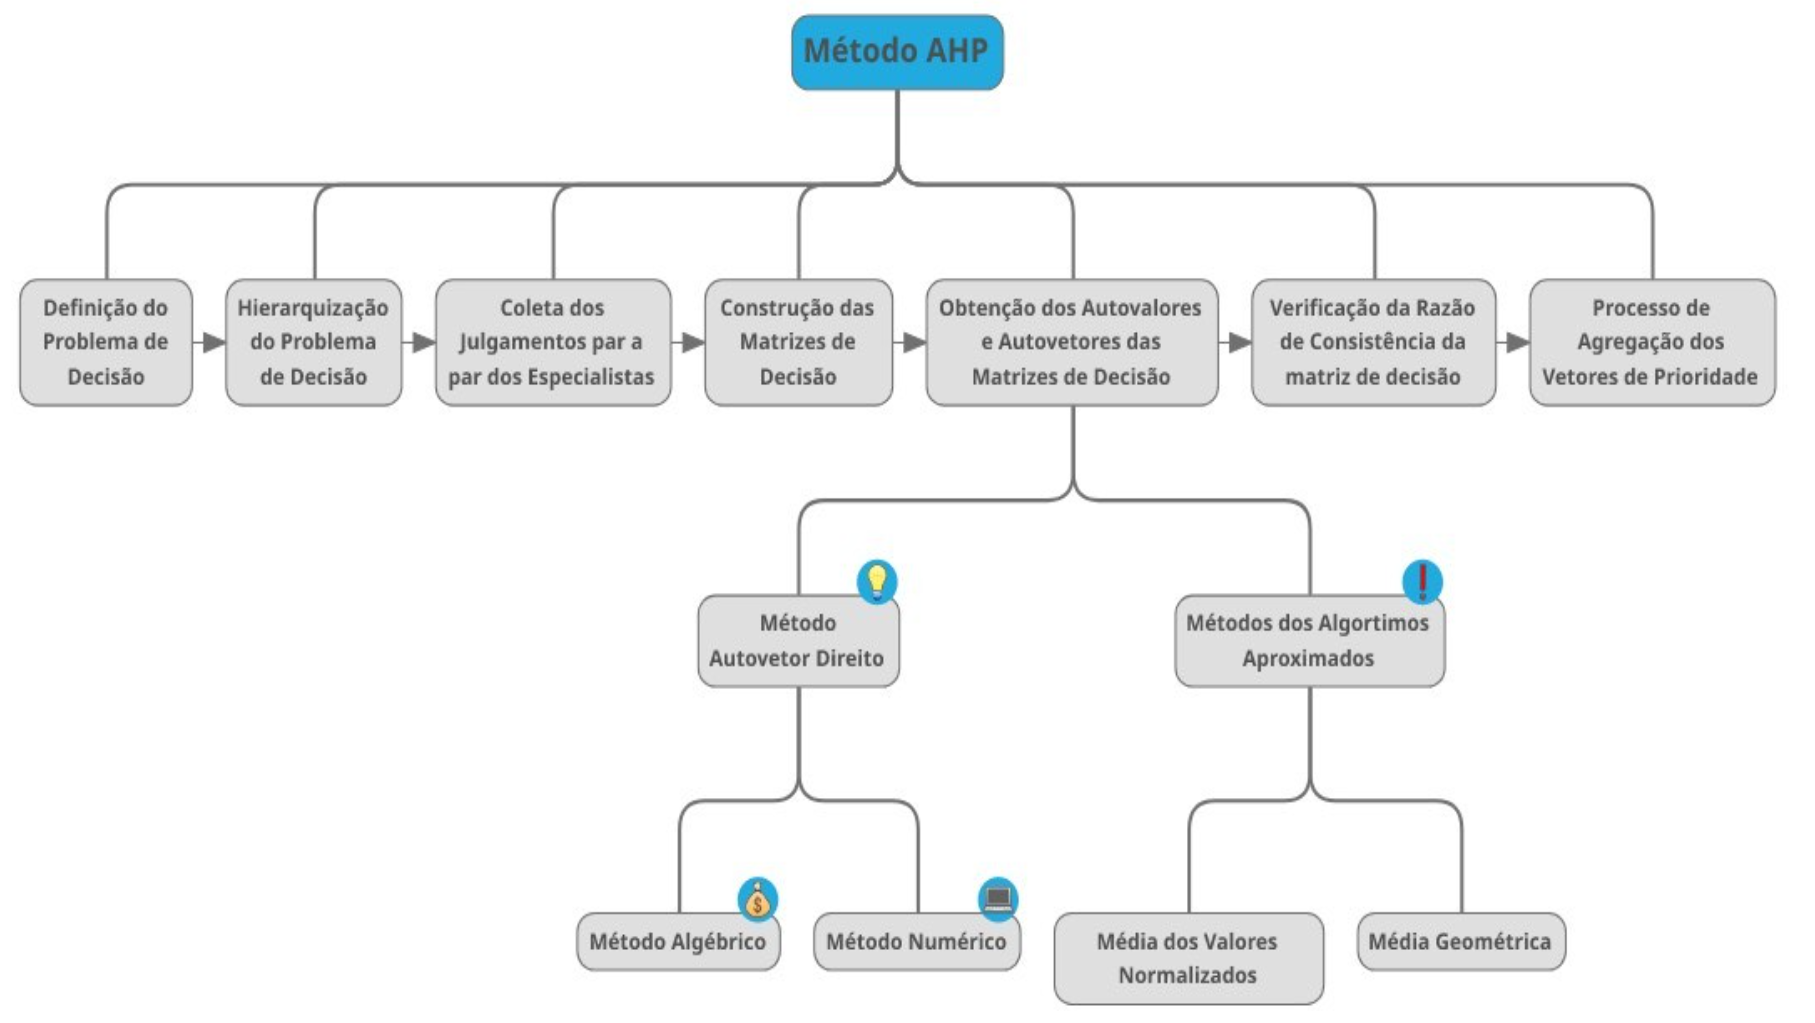

O código abaixo está presente no livro:

**Multiple Criteria Decision Aid Methods, Examples and Python Implementations**

*Cap. 5 p. 118*


## Importação de bibliotecas

In [ ]:
from numpy import *
import scipy.sparse.linalg as sc
import matplotlib.pyplot as plt
from graphviz import Digraph, Source
from IPython.display import Image

## Funções para plotar gráfico e diagrama

In [ ]:
# Gráfico classificação final
def plot(a, b):
    """
    a: matriz com as pontuações (scores),
    b: string descrevendo o método
    """
    scores = a
    yaxes_list = [0.2] * size(scores, 0)
    plt.plot(yaxes_list, scores, 'ro')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    plt.axis([0, 0.7, min(scores) - 0.05, max(scores) + 0.05])
    plt.title(b + " resultados")
    plt.ylabel("Scores (pontuações)")
    plt.legend()
    plt.grid(True)
    z1 = []

    for i in range(size(scores, 0)):
        z1.append(' (Action ' + str(i + 1) + ')')
    z = [str(a) + b for a, b in zip(scores, z1)]

    for X, Y, Z in zip(yaxes_list, scores, z):
        plt.annotate('{}'.format(Z), xy = (X, Y),
            xytext=(10, -4), ha ='left',
            textcoords = 'offset points')
    plt.show()

In [ ]:
# Diagrama de classificação final
def graph(scores, b):
    print('scores: ', scores)
    """
    scores: matriz com as pontuações (scores),
    b: string descrevendo a pontuação (score)
    """
    s = Digraph('Actions', node_attr = {'shape': 'plaintext'}, filename="ex.gv", format="png")
    s.body.extend(['rankdir = LR'])

    x = sort(scores)
    y = argsort(scores)

    for i in y:
        s.node('action' + str(i), label='''<
        <TABLE BORDER="0" CELLBORDER="1"
                CELLSPACING="0" CELLPADDING="4">
            <TR>
                <TD COLSPAN="2" bgcolor="grey" >Action
                    ''' + str(y[i] + 1) + '''</TD>
            </TR>
            <TR>
                <TD>''' + b + '''</TD>
                <TD>''' + str(x[i]) + '''</TD>
            </TR>
        </TABLE>>''')
    k = []

    for q in range(len(scores) - 1):
        k.append(['action' + str(q + 1), 'action' + str(q)])
    s.edges(k)
    output_file = "Actions"

    s.render(output_file)
    Image("Actions.png")

## Método de soma de coluna normalizada

In [ ]:
def norm(x):
    """ x: matriz de comparação para os critérios ou alternativas """

    # vetor contendo a soma de cada coluna de x:
    k = array(sum(x, 0))

    # normalização:
    z = array([[round(x[i, j] / k[j], 3) # round: arredonda pra 3 casas decimais
        for j in range(x.shape[1])]
            for i in range(x.shape[0])])
    return z


## Método da média geométrica

In [ ]:
def geomean(x):
    """x: pairwise comparison matrix for the criteria or the alternatives"""

    # z: array de '1's contendo a quantidade de linhas de x
    z = [1] * x.shape[0] # shape => dimensão de x

    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            z[i] = z[i] * x[i][j]
        z[i] = pow(z[i], (1 / x.shape[0])) # pow: retorna z[i] ^ (1 / x.shape[0])
    return z

## Método AHP

In [ ]:
# método AHP: chama as outras funções
def ahp(PCM, PCcriteria, m, n, c):
    """
    PCM: matriz de comparação das alternativas,
    PCcriteria: matriz de comparação dos critérios,
    m: número de alternativas,
    n: número de critérios,
    c: método para estimar um vetor de prioridade
      (1: autovetor, 2: soma de coluna normalizada e 3: média geométrica)
    """

    # calcula o vetor de prioridade de critérios
    # eigenvector (autovetor)
    if c == 1:
        val, vec = sc.eigs(PCcriteria, k = 1, which = 'LM')
        eigcriteria = real(vec)
        w = eigcriteria / sum(eigcriteria)
        w = array(w).ravel()

    # soma de coluna normalizada
    elif c == 2:
        normPCcriteria = norm(PCcriteria)
        w = array(sum(normPCcriteria, 1) / n)

    else: # média geométrica
        GMcriteria = geomean(PCcriteria)
        w = GMcriteria / sum(GMcriteria)
        print('PCcriteria ', PCcriteria)
        print('GMcriteria ', GMcriteria)
        print('w ', w)


    # calcula os vetores de prioridade local para as alternativas
    S = []
    for i in range(n):
        # eigenvector (autovetor)
        if c == 1:
            val, vec = sc.eigs(PCM[i * m:i * m + m, 0:m],
                k = 1, which = 'LM')
            eigalter = real(vec)
            s = eigalter / sum(eigalter)
            s = array(s).ravel()

        # soma de coluna normalizada
        elif c == 2:
            normPCM = norm(PCM[i * m:i * m + m, 0:m])
            s = array(sum(normPCM, 1) / m)

        # média geométrica
        else:
            GMalternatives = geomean(PCM[i * m:i * m + m, 0:m])
            s = GMalternatives / sum(GMalternatives)
        S.append(s)
    S = transpose(S)

    # calcula o vetor de prioridade global para as alternativas
    v = S.dot(w.T)

    return v

## Função principal

In [ ]:
def main(a, b, c):
    """ a, b e c: flags;
    Se a e b estiverem setados como 'y', eles imprimem os resultados,
    qualquer outra coisa não imprime os resultados.
    Se c = 1: utiliza o método do autovetor;
    Se c = 2: utiliza o método do soma de coluna normalizada;
    Senão, utiliza o método da média geométrica.
    """

    # m: número de alternativas
    m = 6
    # n: número de critérios
    n = 4
    # random indices (RI): índices aleatórios para verificação de consistência
    RI = [0, 0, 0.58, 0.90, 1.12, 1.24, 1.32, 1.41, 1.45, 1.49]

    # pairwise comparison matrix: matriz de comparação dos critérios
    PCcriteria = array ([[1, 1, 5, 3],
                         [1, 1, 5, 3],
                         [1/5, 1/5, 1, 1/3],
                         [1/3, 1/3, 3, 1]])

    # verificação de consistência para matriz de comparação dos critérios
    lambdamax = amax(linalg.eigvals(PCcriteria).real) # eigvals: calcula os autovalores de uma matriz
    CI = (lambdamax - n) / (n - 1)
    CR = CI / RI[n - 1]

    print("Índice de inconsistência dos critérios: ", CR)

    if CR > 0.1:
        print("A matriz de comparação dos critérios é inconsistente")

    # pairwise comparison matrix: matriz de comparação das alternativas
    PCM1 = array([[1, 5, 1, 1, 1/3, 3],
                [1/5, 1, 1/3, 1/5, 1/7, 1],
                [1, 3, 1, 1/3, 1/5, 1],
                [1, 5, 3, 1, 1/3, 3],
                [3, 7, 5, 3, 1, 7],
                [1/3, 1, 1, 1/3, 1/7, 1]])

    PCM2 = array([[1, 7, 3, 1/3, 1/3, 1/3],
                [1/7, 1, 1/3, 1/7, 1/9, 1/7],
                [1/3, 3, 1, 1/5, 1/5, 1/5],
                [3, 7, 5, 1, 1, 1],
                [3, 9, 5, 1, 1, 1],
                [3, 7, 5, 1, 1, 1]])

    PCM3 = array([[1, 1/9, 1/7, 1/9, 1, 1/5],
                [9, 1, 1, 1, 5, 3],
                [7, 1, 1, 1, 5, 1],
                [9, 1, 1, 1, 7, 3],
                [1, 1/5, 1/5, 1/7, 1, 1/3],
                [5, 1/3, 1, 1/3, 3, 1]])

    PCM4 = array([[1, 1/5, 1/5, 1/3, 1/7, 1/5],
                [5, 1, 1, 3, 1/3, 1],
                [5, 1, 1, 1, 1/3, 1],
                [3, 1/3, 1, 1, 1/7, 1],
                [7, 3, 3, 7, 1, 5],
                [5, 1, 1, 1, 1/5, 1]])

    allPCM = vstack((PCM1, PCM2, PCM3, PCM4)) # vstack: "concatena" em um array

    # consistency check for pairwise comparison matrix of the alternatives
    for i in range(n):
        lambdamax = amax(linalg.eigvals(allPCM[i * m:i * m + m, 0:m]).real)
        CI = (lambdamax - m) / (m - 1)
        CR = CI / RI[m - 1]
        print("Índice de inconsistência das alternativas para critério ",
              (i + 1), ": ", CR)

        if CR > 0.1:
            print("A matriz de comparação das alternativas para o critério ", (i + 1),
            "é inconsistente")

    # chama método ahp
    scores = ahp(allPCM, PCcriteria, m, n, c)

    # resultados
    print("Prioridades globais = ", scores)

    # gráficos dos resultados
    if a == 'y':
        graph(around(scores, 3), "Score")

    if b == 'y':
        plot(around(scores, 3), "AHP")

Índice de inconsistência dos critérios:  0.01610868948440318
Índice de inconsistência das alternativas para critério  1 :  0.03349113123332669
Índice de inconsistência das alternativas para critério  2 :  0.026437064499443722
Índice de inconsistência das alternativas para critério  3 :  0.022144721786307425
Índice de inconsistência das alternativas para critério  4 :  0.03978511204173825
Prioridades globais =  [0.11737682 0.07132502 0.09472062 0.21164765 0.35008026 0.15484963]
scores:  [0.117 0.071 0.095 0.212 0.35  0.155]


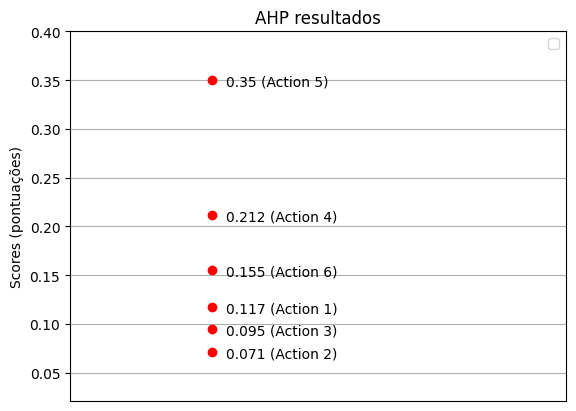

In [ ]:
if __name__ == '__main__':
    main('y', 'y', 1)

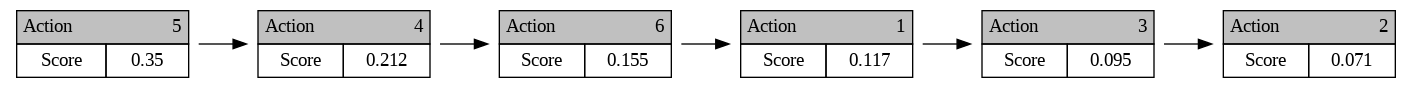

In [ ]:
fname = "Actions.png"
Image(fname)